## Black Friday
### Problen Statement
A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.
Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

import all necessary package

In [122]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Importing dataset 

In [81]:
dataset_train = pd.read_csv(r'./Data/train.csv')
dataset_test = pd.read_csv(r'./Data/test.csv')

Check first 5 data

In [82]:
print(len(dataset_train))
print(len(dataset_test))
dataset_train.head()

550068
233599


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


store categorical variables column name and dictionary with column to unique value mapping associated with it

In [83]:
columns = dataset_train.columns
dic_columnwise_acceped_value = {}
for i in columns[2:-1] :
    temp1 = dataset_train[i].unique()
    temp2 = dataset_test[i].unique()
    try :
        if np.isnan(temp1).any() and np.isnan(temp2).any() :
            temp1 = temp1[~np.isnan(temp1)]
    except TypeError :
        pass
    tem_dup =  np.hstack([temp1, temp2])
    tem_dup = np.unique(tem_dup)
    dic_columnwise_acceped_value[i] = list(tem_dup)
    print(i,tem_dup)

Gender ['F' 'M']
Age ['0-17' '18-25' '26-35' '36-45' '46-50' '51-55' '55+']
Occupation [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
City_Category ['A' 'B' 'C']
Stay_In_Current_City_Years ['0' '1' '2' '3' '4+']
Marital_Status [0 1]
Product_Category_1 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Product_Category_2 [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. nan]
Product_Category_3 [ 3.  4.  5.  6.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. nan]


check and print if any column contain null or NaN value

In [84]:
print(dataset_train.isna().sum())
print(dataset_test.isna().sum())

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64
User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64


In this case product_category_2 and product_category_3 contain null value
Create SimpleImputer class to replace NaN to 0 so that later on it can be HotEncoded

In [85]:
def replace_NaN(data, columns, *args) :    
    mp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=999)
    transformed_val = mp.fit_transform(data.iloc[:,[columns.get_loc(i) for i in list(args)]].values)
    df = data.copy()
    df[list(args)] = transformed_val
    return df

replacing Nan from two columns Product_Category_2 Product_Category_3

In [86]:
dataset_train = replace_NaN(dataset_train, dataset_train.columns, 'Product_Category_2', 'Product_Category_3')
dataset_test = replace_NaN(dataset_test, dataset_test.columns, 'Product_Category_2', 'Product_Category_3')

In [99]:
dataset_train.head(6)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,999.0,999.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,999.0,999.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,999.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,999.0,999.0,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,999.0,15227


Now for each categorical column we created n-1 number of dummy variable which contain either 0 or 1
create a function which take data, column Names list, column name (In which we want to perform an operation)
and remove column name which we want to remove in order to avoid dummy variable trap

In [100]:
def replace_column_with_Dummy_Columns(data, columns, column_name, remove_column_val, remove_one_dummy=False, dtype=int) :
    temp = pd.get_dummies(data[column_name], prefix=column_name, dtype=dtype)
    col = list(temp.columns)
    removed_col = column_name+'_'+remove_column_val
    removed_col_index = col.index(removed_col)
    temp = temp[col[:removed_col_index] + col[removed_col_index+(1 if remove_one_dummy else 0):]] # removing to avoid dummy variable trap
    previous = data[columns[:columns.index(column_name)]]
    after = data[columns[columns.index(column_name)+1:]]
    previous = previous.join(temp)
    previous = previous.join(after)
    return previous

For One categorical column of training data create hotencoded column from function replace_column_with_Dummy_Columns

In [105]:
def get_dummy_dataset(data, columns, cat_col_list) :
    col = cat_col_list
    df = data[list(filter(lambda x: x not in cat_col_list, columns))]
    for i in cat_col_list :
        dic = data[i].value_counts().to_dict()
        max_key = max(dic, key=dic.get) # for non column removal it automatically contain maximim number
        # so we dont need to remove it seperately
        data = replace_column_with_Dummy_Columns(data, col, i, str(max_key))
        col = list(data.columns)
    df= df.join(data)
    return df

Iterating through each categorical column in training and testing set to get dummy coded column 

In [106]:
def get_encoded_dataset(columns, dataset) :
    category_column = ['Gender', 'Occupation', 'City_Category', 'Product_Category_1', 'Product_Category_2' ,'Product_Category_3']
    label_encoded_column = ['Age', 'Stay_In_Current_City_Years']
    df = get_dummy_dataset(dataset, columns, category_column)
    # label encode data
    for i in label_encoded_column :
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    return df

create hot encoded data for training and testing set

In [118]:
def get_train_test_data(df, slice_index, data_label) :
    sliced_train_data = df.loc[:slice_index-1]
    sliced_test_data = df.loc[slice_index:]
    sliced_train_data = pd.concat([sliced_train_data, data_label], sort=False, axis=1)
    return sliced_train_data, sliced_test_data
def get_encoded_data(column, dataset_train, dataset_test) :
    #print(column[:-1])
    df = dataset_train[column[:-1]] # seperate label column
    df = pd.concat([df, dataset_test], ignore_index=True) # merge 2 dataframe
    df = get_encoded_dataset(column[:-1], df)
    return df
def PCA_feature_selection_graph(df) :
    pca = PCA().fit(df)
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Black friday Explained Variance')
    plt.show()
def PCA_feature_selection(df, n_comp) :
    pca = PCA(n_components=n_comp)
    return pca.fit_transform(df)

Apply PCA to reduce the dimension

In [138]:
columns = list(dataset_train.columns)
df = get_encoded_data(columns, dataset_train, dataset_test)
df = df.drop(['User_ID', 'Product_ID'], axis = 1)
columns = list(df.columns)

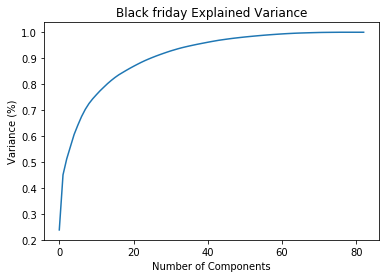

In [139]:
PCA_feature_selection_graph(df)

From graph we will select 60 principal components 

In [140]:
data_label = dataset_train[[columns[-1]]]
slice_index = len(dataset_train)
df = PCA_feature_selection(df, 60)
df = pd.DataFrame(df, columns= columns)

KeyError: "None of [Index(['Product_Category_3_999.0'], dtype='object')] are in the [columns]"

In [141]:
df

,Age,Stay_In_Current_City_Years,Marital_Status,Gender_F,Gender_M,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,...,Product_Category_3_10.0,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0,Product_Category_3_999.0
0,0,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,2,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,6,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,2,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,4,2,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,4,2,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,4,2,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,2,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


create generic model object which store all the Information of related model

In [18]:
class ModelObject :
    def __init__(self, name) :
        self._name = name
        self._cross_validation_score = None
        self._model = None
    @property
    def name(self) :
        return self._name
    @property
    def cross_validation_score(self) :
        return self._cross_validation_score
    @cross_validation_score.setter
    def cross_validation_score(self, value) :
        try :
            self._cross_validation_score = value
        except Exception as e:
            raise Exception('value object is not in format',e)
    @property
    def model(self) :
        return self._model
    @model.setter
    def model(self, value) :
        self._model = value
        self._cross_validation_score = None
    def __str__(self) :
        res = '\n'
        res += 'Model Name :- ' + self._name + '\n'
        res += 'cross validation score :- ' + str(self._cross_validation_score) + '\n'
        if self._model != None :
            res += 'Model Parameter ' + str(self._model.get_params) + '\n'
        else :
            res += '\n'
        return res

Since data_test doesn't contain target variable thats why I am splitting data_train to X_train, y_train, X_test and y_test

create a function which eleminate feature from backward and return train, test split

In [19]:
def get_feature_list(data) :
    return list(data.columns)
def get_dataSet_with_eliminated_features(data, label_col, eliminated_features_count=0, ahead_start=2) :
    f_count = len(get_feature_list(data))
    if label_col < 0 or label_col >= f_count:
        return None
    if (eliminated_features_count  < 0) or (eliminated_features_count > (f_count - ahead_start - 1)) :
        return None
    col_index_list = list(range(ahead_start, f_count))
    del col_index_list[col_index_list.index(label_col)]
    col_index_list = col_index_list if eliminated_features_count == 0 else col_index_list[:-eliminated_features_count]
    #print(col_index_list)
    #print(label_col)
    X = data.iloc[:,col_index_list].values
    y = data.iloc[:, label_col].values
    X_train, X_test, y_train , y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=0)
    return (X_train, X_test, y_train , y_test)

For selecting feature we will go through backward elemination methods. since except gender all 
categorical variable has more then 2 level so we can't apply biserial correlation for binary.

## Build Models
### 1.Linear Regression

In [20]:
def get_optimal_modellr(X_train, y_train) :
    seed_k_fold = 7
    no_of_split = 10
    scoring = 'neg_mean_squared_error'
    lr = ModelObject('Linear Regression')
    kfold = model_selection.KFold(n_splits= no_of_split, random_state=seed_k_fold)
    lr.model = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
    cv_results = -model_selection.cross_val_score(lr.model, X_train, y_train,cv=kfold, scoring=scoring)
    """The unified scoring API always maximizes the score, so scores which need to be minimized are negated
    in order for the unified scoring API to work correctly. The score that is returned is therefore negated
    when it is a score that should be minimized and left positive if it is a score that should be maximized."""
    cv_results.sort(axis=-1, kind='mergesort', order=None)
    lr.cross_validation_score = cv_results
    return lr

get linear model without any regularization and check its RMSE as the performance metrix

In [21]:
col_len = len(get_feature_list(data_train))
for i in range(5) :
    data = get_dataSet_with_eliminated_features(data_train, col_len - 1, i)
    if data is not None :
        X_train, X_test, y_train , y_test = data[0], data[1], data[2], data[3]
        lr = get_optimal_modellr(X_train, y_train)
        print('cr mean -',lr.cross_validation_score.mean())

cr mean - 8889010.0525569
cr mean - 8889119.329643253
cr mean - 8914314.381786192
cr mean - 8914245.64527319
cr mean - 8922265.748940362


As we see if we remove feature model performance goes down so we will continue building our model with all feature

In [22]:
data = get_dataSet_with_eliminated_features(data_train, col_len - 1, 0)
if data is not None :
    X_train, X_test, y_train , y_test = data[0], data[1], data[2], data[3]
else :
    assert False

## 2. Ridge Regression

In [23]:
def get_ridge_regression_model(lambda_val) :
    return Ridge(alpha = lambda_val, fit_intercept=True, normalize=False, copy_X=True,
                         max_iter=None, tol=0.001, solver='auto', random_state=0)
def get_optimal_model_ridge(X_train, y_train, verbose=True, lambda_start=0.001, lambda_stop=1.2, no_split=10) :
    seed_k_fold = 7
    no_of_split = no_split
    range_lambda  = np.logspace(lambda_start, lambda_stop, num=no_split)
    kf = model_selection.KFold(n_splits= no_of_split, random_state=seed_k_fold)
    index = 0
    val_score_list = []
    #Applying cross validation for getting appropriate value of lambda
    for train_index, test_index in kf.split(X_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_tr, X_tst = X_train[train_index], X_train[test_index]
        y_tr, y_tst = y_train[train_index], y_train[test_index]
        temp = get_ridge_regression_model(range_lambda[index])
        temp.fit(X_tr,y_tr)
        predicted = temp.predict(X_tst)
        validation_score = mean_squared_error(y_tst, predicted)
        val_score_list.append(validation_score)
        if verbose :
            print('lambda - '+str(range_lambda[index]) + '--validation score '+str(validation_score))
        index += 1
    min_val_score_index = val_score_list.index(min(val_score_list))
    lambda_optimal = range_lambda[min_val_score_index]
    ridge_reg = ModelObject('Ridge Regression')
    ridge_reg.model = get_ridge_regression_model(lambda_optimal)
    ridge_reg.cross_validation_score = val_score_list[min_val_score_index]
    return ridge_reg

In [24]:
# fitting optimal model
rr = get_optimal_model_ridge(X_train, y_train, verbose=True)
rr.model.fit(X_train,y_train)
predicted = rr.model.predict(X_test)
print(mean_squared_error(y_test, predicted))

lambda - 1.0023052380778996--validation score 8922647.530799838
lambda - 1.362141492331366--validation score 8844968.085384028
lambda - 1.8511620758251646--validation score 8846008.861777883
lambda - 2.515745280696361--validation score 8825670.343655938
lambda - 3.4189196073092853--validation score 8841837.975315006
lambda - 4.646341333097262--validation score 8893420.155536015
lambda - 6.314418080347418--validation score 8865594.740417538
lambda - 8.581348815120236--validation score 8947751.548640985
lambda - 11.66212730131956--validation score 9029363.807581186
lambda - 15.848931924611133--validation score 8871717.69304336
8884201.382101309


## 3. Lasso Regression

In [67]:
def get_lasso_regression_model(lambda_val) :
    # precompute - Whether to use a precomputed Gram matrix to speed up calculations
    # warm_start - When set to True, reuse the solution of the previous call to fit as initialization
    return Lasso(alpha = lambda_val, fit_intercept=True, normalize=False, precompute=False,
                            copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False,
                            random_state=0, selection='cyclic')
def get_optimal_model_lasso(X_train, y_train, verbose=True, lambda_start=0.001, lambda_stop=1.2, no_split=10) :
    seed_k_fold = 7
    no_of_split = no_split
    range_lambda  = np.logspace(lambda_start, lambda_stop, num=no_split)
    kf = model_selection.KFold(n_splits= no_of_split, random_state=seed_k_fold)
    index = 0
    val_score_list = []
    #Applying cross validation for getting appropriate value of lambda
    for train_index, test_index in kf.split(X_train):
        X_tr, X_tst = X_train[train_index], X_train[test_index]
        y_tr, y_tst = y_train[train_index], y_train[test_index]
        temp =  get_lasso_regression_model(range_lambda[index])
        temp.fit(X_tr, y_tr)
        predicted = temp.predict(X_tst)
        validation_score = mean_squared_error(y_tst, predicted)
        val_score_list.append(validation_score)
        if verbose :
            print('lambda - '+str(range_lambda[index]) + '--validation score '+str(validation_score))
        index += 1
    min_val_score_index = val_score_list.index(min(val_score_list))
    lambda_optimal = range_lambda[min_val_score_index]
    lasso_reg = ModelObject('Lasso Regression')
    lasso_reg.model = get_lasso_regression_model(lambda_optimal)
    lasso_reg.cross_validation_score = val_score_list[min_val_score_index]
    return lasso_reg

In [68]:
# fitting optimal model
lr = get_optimal_model_lasso(X_train, y_train, verbose=True)
lr.model.fit(X_train,y_train)
predicted = lr.model.predict(X_test)
print(mean_squared_error(y_test, predicted))

lambda - 1.0023052380778996--validation score 8933224.404465677
lambda - 1.362141492331366--validation score 8853332.760609273
lambda - 1.8511620758251646--validation score 8875848.042102413
lambda - 2.515745280696361--validation score 8878554.501639718
lambda - 3.4189196073092853--validation score 8943719.53153637
lambda - 4.646341333097262--validation score 9058969.105726363
lambda - 6.314418080347418--validation score 9121434.939248545
lambda - 8.581348815120236--validation score 9322941.993716482
lambda - 11.66212730131956--validation score 9499112.03191808
lambda - 15.848931924611133--validation score 9501220.522795992
8899300.713580566


## 4.Support vector regression

In [60]:
def get_svr_model(c=1.0) :
    #C = it is a hyperparameter that controls how much we penalize our use of slack variables
    #slack variable - as a value ζthat, roughly, indicates how much we must move our point so that
    #it is correctly and confidently classified
    # gamma - gamma controls the shape of the "peaks" where you raise the points
    kernel = 'rbf' # 'sigmoid' 'linear' 'poly'
    degree = 3 # only when kernel is poly
    gamma = 'auto'
    return SVR(kernel=kernel, degree=degree, gamma=gamma, coef0=0.0, tol=0.001, C=c,
               epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
def get_optimal_model_svr(X_train, y_train, c_start=0.001, c_stop=1.2, verbose=True) :
    range_c  = np.logspace(c_start, c_stop, num=8)
    X_tr, X_tst, y_tr, y_tst = model_selection.train_test_split(X_train, y_train, test_size = 0.1, random_state=0)
    val_score_list = []
    #Applying cross validation for getting appropriate value of c
    for i in range_c:
        temp =  get_svr_model(i)
        temp.fit(X_tr, y_tr)
        predicted = temp.predict(X_tst)
        validation_score = mean_squared_error(y_tst, predicted)
        val_score_list.append(validation_score)
        if verbose :
            print('c - '+str(i) + '--validation score '+str(validation_score))
    min_val_score_index = val_score_list.index(min(val_score_list))
    c_optimal = range_c[min_val_score_index]
    svr_reg = ModelObject('SVR')
    svr_reg.model = get_svr_model(c_optimal)
    svr_reg.cross_validation_score = val_score_list[min_val_score_index]
    return svr_reg

In [ ]:
# fitting optimal model
svr = get_optimal_model_svr(X_train, y_train)
svr.model.fit(X_train,y_train)
predicted = svr.model.predict(X_test)
print(mean_squared_error(y_test, predicted))

## 5.k-nearest neighbors Regression

In [63]:
def get_knr_model(k=5) :
    algo = 'auto' #{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
    return KNeighborsRegressor(n_neighbors=k, weights='uniform', algorithm=algo, leaf_size=30, p=2,
                               metric='minkowski', metric_params=None, n_jobs=-1)
def get_optimal_model_knr(X_train, y_train,k_start=1, k_stop=5, verbose=True) :
    range_k  = np.arange(k_start,k_stop+1,dtype=int)
    X_tr, X_tst, y_tr, y_tst = model_selection.train_test_split(X_train, y_train, test_size = 0.1, random_state=0)
    val_score_list = []
    #Applying cross validation for getting appropriate value of k
    for j in range_k:
        temp = get_knr_model(j)
        temp.fit(X_tr, y_tr)
        predicted = temp.predict(X_tst)
        validation_score = mean_squared_error(y_tst, predicted)
        val_score_list.append(validation_score)
        if verbose :
            print('k - '+str(j) + '--validation score '+str(validation_score))
    knr_reg = ModelObject('KNR')
    k_optimal = val_score_list.index(min(val_score_list)) + 1
    knr_reg.model = get_knr_model(k_optimal)
    knr_reg.cross_validation_score = val_score_list[k_optimal-1]
    return knr_reg

In [64]:
knr = get_optimal_model_knr(X_train, y_train, k_start=5, k_stop=9, verbose=True)
knr.model.fit(X_train,y_train)
predicted = knr.model.predict(X_test)
print(mean_squared_error(y_test, predicted))

k - 1--validation score 16708762.873994455
k - 2--validation score 12892462.134447575
k - 3--validation score 11730556.01017033
k - 4--validation score 11230281.58046772
k - 5--validation score 10985423.541005317


NameError: name 'get_knn_model' is not defined

## 6. Decision Tree Regression

In [73]:
def get_decision_tree_model(max_depth = None, min_samples_lf = 1, min_samples_splt = 2) :
    criteria = 'mse'
    split = 'best'
    return DecisionTreeRegressor(criterion=criteria, splitter=split, max_depth=max_depth,
                                 min_samples_split=min_samples_splt, min_samples_leaf=min_samples_lf,
                                 min_weight_fraction_leaf=0.0,max_features=None, random_state=0,
                                 max_leaf_nodes=None,min_impurity_decrease=0.0,
                                 min_impurity_split=None, presort=False)
def get_optimal_model_decision_tree(X_train, y_train, verbose = True) :
    max_depth, min_samples_lf, min_samples_splt  = None, 1, 2
    temp =  get_decision_tree_model(max_depth, min_samples_lf, min_samples_splt)
    temp.fit(X_train, y_train)
    if verbose :
        print('max depth {0} , minimum sample leaf - {1} minimum sample split {2}'.format(str(max_depth), 
                                                                                          str(min_samples_lf),
                                                                                         str(min_samples_splt)))
    dt_reg = ModelObject('Decision Tree')
    dt_reg.model = temp
    return dt_reg

In [74]:
dtr = get_optimal_model_decision_tree(X_train, y_train)
predicted = dtr.model.predict(X_test)
print(mean_squared_error(y_test, predicted))

max depth None , minimum sample leaf - 1 munimum sample split 2
11008802.070955379


In [ ]:
from sklearn.tree import plot_tree
plot_tree(dtr.model)
max_depth=8,6,12 min_samples_split=10, min_samples_leaf=10, 

[Text(265.391244838713, 215.84117647058824, 'X[34] <= 0.5\nentropy = 25225903.53\nsamples = 440054\nvalue = 9262.677'),
 Text(218.52830201514055, 212.6435294117647, 'X[38] <= 0.5\nentropy = 18865341.213\nsamples = 327750\nvalue = 7774.516'),
 Text(203.83298607514416, 209.44588235294117, 'X[42] <= 0.5\nentropy = 15415079.049\nsamples = 311370\nvalue = 7350.793'),
 Text(193.95142172917724, 206.24823529411765, 'X[48] <= 0.5\nentropy = 13324729.911\nsamples = 307291\nvalue = 7186.56'),
 Text(181.4485414125603, 203.05058823529413, 'X[35] <= 0.5\nentropy = 11644986.133\nsamples = 299496\nvalue = 6989.606'),
 Text(161.7691668725138, 199.85294117647058, 'X[47] <= 0.5\nentropy = 10242736.439\nsamples = 280375\nvalue = 6698.695'),
 Text(152.88939728216678, 196.65529411764706, 'X[39] <= 0.5\nentropy = 8710882.166\nsamples = 275306\nvalue = 6549.103'),
 Text(140.091806758883, 193.4576470588235, 'X[36] <= 0.5\nentropy = 7568286.558\nsamples = 272343\nvalue = 6442.957'),
 Text(120.85402150763058, 19

In [ ]:
df1 = pd.DataFrame({'A':[1,2,3,4]})
df2 = pd.DataFrame({'B':[5,6,7,8], 'C': [6,4,3,2]})
dd = pd.concat([df1, df2], sort=False, axis=1)
dd

In [108]:
df1 = pd.DataFrame({'A':[1,2,3,4]})
df2 = pd.DataFrame({'A':[5,6,7,8]})
dd = pd.concat([df1, df2], sort=False, ignore_index=True, axis=0)
dd

,A
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
